In [7]:

!pip install ultralytics gtts IPython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.8 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


In [8]:
import torch
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
from ultralytics import YOLO
from gtts import gTTS
import IPython.display as ipd
import numpy as np


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
KNOWN_HEIGHTS = {
    "person": 1.7,
    "chair": 1.0,
    "bottle": 0.25,
    "car": 1.5
}

FOCAL_LENGTH = 600


In [10]:
def estimate_distance(class_name, box_height):
    if class_name not in KNOWN_HEIGHTS or box_height == 0:
        return None
    return round((KNOWN_HEIGHTS[class_name] * FOCAL_LENGTH) / box_height, 2)



In [11]:
def get_direction(x1, x2, frame_width):
    box_center = (x1 + x2) // 2
    frame_center = frame_width // 2

    if box_center < frame_center - 50:
        return "on your left"
    elif box_center > frame_center + 50:
        return "on your right"
    else:
        return "ahead"


In [12]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]


Saving WhatsApp Image 2026-01-17 at 4.33.06 PM.jpeg to WhatsApp Image 2026-01-17 at 4.33.06 PM.jpeg


In [13]:
model = YOLO("yolov8n.pt")


In [14]:
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
frame_height, frame_width, _ = image_rgb.shape


In [15]:
results = model(image_rgb)



0: 640x448 2 persons, 309.6ms
Speed: 12.0ms preprocess, 309.6ms inference, 46.4ms postprocess per image at shape (1, 3, 640, 448)


In [16]:
audio_messages = []

for result in results:
    for box in result.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls_id = int(box.cls[0])
        class_name = model.names[cls_id]

        box_height = y2 - y1
        distance = estimate_distance(class_name, box_height)
        direction = get_direction(x1, x2, frame_width)

        label = class_name
        message = class_name

        if distance:
            label += f" {distance}m"
            message += f" {distance} meters"

        label += f" ({direction})"
        message += f" {direction}"

        audio_messages.append(message)

        cv2.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_rgb, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)


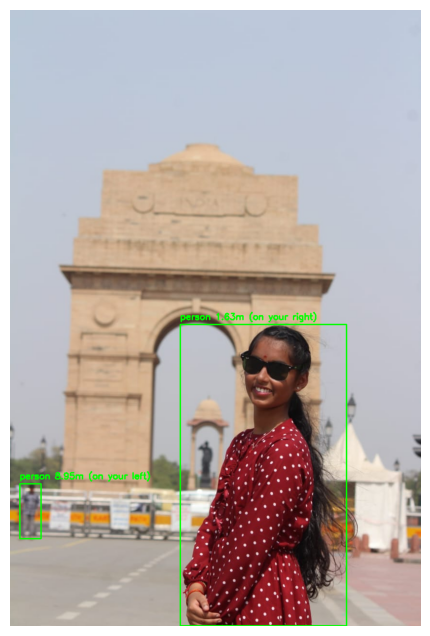

In [17]:
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


In [18]:
if audio_messages:
    final_text = "Detected objects: " + ", ".join(set(audio_messages))
    print(final_text)

    tts = gTTS(final_text)
    tts.save("output.mp3")
    ipd.display(ipd.Audio("output.mp3", autoplay=True))
else:
    print("No objects detected")


Detected objects: person 8.95 meters on your left, person 1.63 meters on your right
